<a href="https://colab.research.google.com/github/A-Istrate/80629_Project/blob/main/ML_TPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import math
import copy
from random import seed
from random import random
import matplotlib.pyplot as plt  # import matplotlib for plotting and visualization
import matplotlib
import PIL
from PIL import Image
import PIL.Image
import tensorflow as tf
import pathlib
import os
import re
import gc
import sklearn
from tensorflow.keras import layers
from sklearn.utils import class_weight
from sklearn.metrics import classification_report

Checking our images

In [4]:
gc.collect()

37

In [5]:
## images path
path_s = r"C:\Users\istra\Google Drive\Cours HEC\Maitrise\Semestre 2\Machine_Learning\TP GROUPE\book_covers_final"
path = pathlib.Path(path_s)
image_count=len(list(path.glob('*/*/*.jpg')))
print(image_count)

43325


In [6]:
### Train Validation TEST and survey
path_train = pathlib.Path(r"C:\Users\istra\Google Drive\Cours HEC\Maitrise\Semestre 2\Machine_Learning\TP GROUPE\book_covers_final\train")
path_valid = pathlib.Path(r"C:\Users\istra\Google Drive\Cours HEC\Maitrise\Semestre 2\Machine_Learning\TP GROUPE\book_covers_final\valid")
path_test = pathlib.Path(r"C:\Users\istra\Google Drive\Cours HEC\Maitrise\Semestre 2\Machine_Learning\TP GROUPE\book_covers_final\test")
path_survey = pathlib.Path(r"C:\Users\istra\Google Drive\Cours HEC\Maitrise\Semestre 2\Machine_Learning\TP GROUPE\book_covers_final\survey")


Checking a childrens book

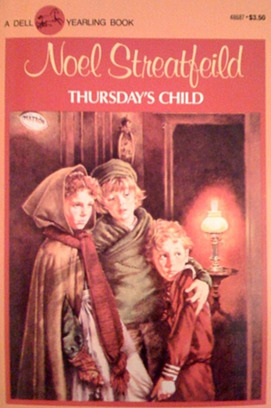

In [7]:
children = list(path.glob('./train/Childrens/*'))
PIL.Image.open(str(children[12]))

Creating a dataset

In [8]:
## Image parameters
batch_size =32
img_height = 150
img_width =100

In [187]:
## train
list_train = tf.data.Dataset.list_files(str(str(path_train)+"\*/*.jp*"),shuffle=False)
list_train = list_train.shuffle(len(list_train),reshuffle_each_iteration=False)
## valid
list_valid = tf.data.Dataset.list_files(str(str(path_valid)+"\*/*.jp*"),shuffle=False)
list_valid = list_valid.shuffle(len(list_valid),reshuffle_each_iteration=False)
## test
list_test = tf.data.Dataset.list_files(str(str(path_test)+"\*/*.jp*"),shuffle=False)
list_test = list_test.shuffle(len(list_test),reshuffle_each_iteration=False)
## survey
list_survey = tf.data.Dataset.list_files(str(str(path_survey)+"\*/*.jp*"),shuffle=False)
list_survey = list_survey.shuffle(len(list_survey),reshuffle_each_iteration=False)

In [188]:
a = [str(o.numpy()).rsplit("\\")[-1] for o in list_train]
b = [str(o.numpy()).rsplit("\\")[-1]  for o in list_valid]
c = [str(o.numpy()).rsplit("\\")[-1]  for o in list_test]

In [189]:
len(set(a).intersection(b))

0

In [190]:
len(set(a).intersection(c))

0

In [191]:
len(set(c).intersection(b))

0

In [193]:
for f in list_survey.take(5):
  print(f.numpy())

b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers_final\\survey\\Science Fiction\\Science Fiction_1228.jpg'
b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers_final\\survey\\Poetry\\Poetry_15744.jpg'
b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers_final\\survey\\Historical\\Historical_11204.jpg'
b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers_final\\survey\\Fantasy\\Fantasy_50135.jpg'
b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers_final\\survey\\Politics & History\\Politics & History_29185.jpg'


In [15]:
# getting the classes names
class_names = np.array(sorted([item.name for item in path_train.glob('*') if os.path.isdir(item)]))
print(class_names)

['Biography' 'Childrens' 'Fantasy' 'Historical' 'Horror' 'Mystery & Crime'
 'Poetry' 'Politics & History' 'Religion & Philosophy' 'Romance'
 'Science Fiction' 'Sequential Art' 'Young Adult']


In [194]:
## Number of items in each sample
print(tf.data.experimental.cardinality(list_train).numpy())
print(tf.data.experimental.cardinality(list_valid).numpy())
print(tf.data.experimental.cardinality(list_test).numpy())
print(tf.data.experimental.cardinality(list_survey).numpy())

31653
7926
3746
65


In [197]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
 
  return tf.argmax(one_hot)

In [163]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [186]:
def process_path(file_path):
    label = get_label(file_path)
  # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
         
    return img,label


In [198]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.AUTOTUNE
train_ds = list_train.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = list_valid.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = list_test.map(process_path, num_parallel_calls=AUTOTUNE)


In [199]:
survey_ds = list_survey.map(process_path, num_parallel_calls=AUTOTUNE)

Image shape:  (150, 100, 3)
Label:  Science Fiction


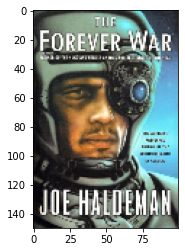

In [200]:
for image, label in survey_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", class_names[label.numpy()])
  plt.imshow(image.numpy().astype("uint8"))

Image augmentation

In [22]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.2)
])


In [205]:
def configure_for_performance_train(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000,reshuffle_each_iteration=True)
  #print(ds)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def configure_for_performance_other(ds):
  ds = ds.cache()
  # ds = ds.shuffle(buffer_size=1000,reshuffle_each_iteration=False)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance_train(train_ds)
val_ds = configure_for_performance_other(val_ds)
test_ds = configure_for_performance_other(test_ds)
survey_ds = configure_for_performance_other(survey_ds)

In [25]:
gc.collect()

2659

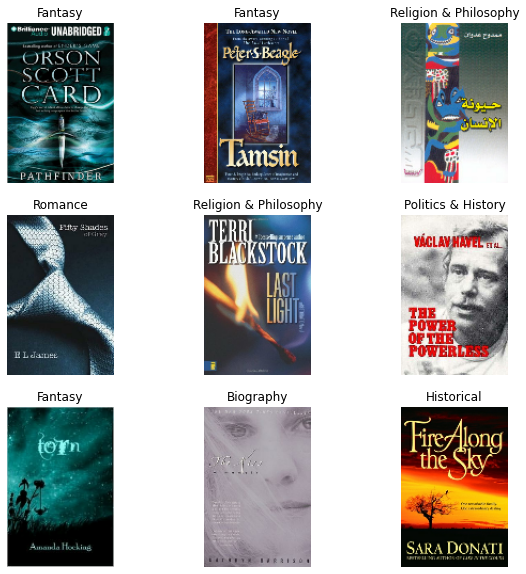

In [32]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

Classes

In [50]:
num_classes=13

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3,padding='same',strides=1, activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(32, 3,padding='same',strides=1,  activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(64, 3,padding='same',strides=1,  activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(128, 3,padding='same',strides=1,  activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax')
])
model.compile(
   
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.001,
        epsilon=0.01
    ),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [51]:
history=model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
990/990 [==============================] - 148s 149ms/step - loss: 2.4349 - accuracy: 0.1735 - val_loss: 2.3460 - val_accuracy: 0.1988
Epoch 2/20
990/990 [==============================] - 150s 152ms/step - loss: 2.3479 - accuracy: 0.2065 - val_loss: 2.3071 - val_accuracy: 0.2279
Epoch 3/20
990/990 [==============================] - 151s 152ms/step - loss: 2.3132 - accuracy: 0.2210 - val_loss: 2.2898 - val_accuracy: 0.2383
Epoch 4/20
990/990 [==============================] - 151s 153ms/step - loss: 2.2840 - accuracy: 0.2334 - val_loss: 2.2486 - val_accuracy: 0.2427
Epoch 5/20
990/990 [==============================] - 151s 153ms/step - loss: 2.2589 - accuracy: 0.2406 - val_loss: 2.2127 - val_accuracy: 0.2610
Epoch 6/20
990/990 [==============================] - 150s 152ms/step - loss: 2.2296 - accuracy: 0.2491 - val_loss: 2.1796 - val_accuracy: 0.2681
Epoch 7/20
990/990 [==============================] - 151s 153ms/step - loss: 2.1946 - accuracy: 0.2634 - val_loss: 2.1481 -

In [227]:
def prediction_score(valid,predictions,cnames=class_names):
    pred = np.argmax(predictions, axis=1)
    pred2 = np.argsort(predictions,axis=1)[:,-2]
    pred3 = np.argsort(predictions,axis=1)[:,-3]
    dict_c = dict(enumerate(cnames))
    scores=[]
    for v,p1,p2,p3 in zip(valid,pred,pred2,pred3):
        score=0
        top1 = 0
        top3 = 0
        if v == p1: score=1
        elif v == p2: score =0.75
        elif v == p3: score =0.5
        if score == 1 : top1 =1
        if score >=0.5 : top3=1
        scores.append([dict_c.get(v),score,top1,top3])
    scores_df = pd.DataFrame(scores,columns=["genre","score","top1","top3"])
    meanscore =np.round(scores_df["score"].mean(),3)
    sumtop = np.sum(scores_df["top1"].sum())
    print("The average score is %s" %meanscore)
    print("Correctly predicted %s / %s" % (sumtop,len(scores_df)))
    print(scores_df.groupby("genre").agg({"score":"mean","top1":["sum","mean"],"top3":["sum","mean"],"genre":"count"}).round(2))
    return 

In [212]:
def show_results(history,model,test_ds=test_ds):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    predictions = model.predict(test_ds)
    predicted_classes = np.argmax(predictions, axis=1)
    oclasses = list()
    oclasses = [[c.numpy() for c in object[1]]for object in test_ds]
    original_classes = np.concatenate(oclasses).ravel()
    print(classification_report(original_classes, predicted_classes, target_names=class_names,zero_division=0))
    prediction_score(original_classes,predictions)

In [53]:
model.save("model_ns_nd.h5")

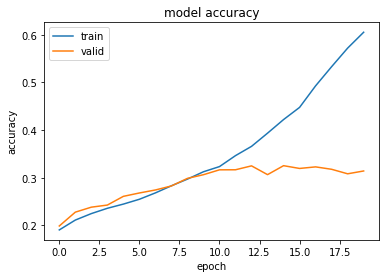

                       precision    recall  f1-score   support

            Biography       0.14      0.09      0.11       169
            Childrens       0.30      0.28      0.29       140
              Fantasy       0.41      0.49      0.45       749
           Historical       0.22      0.23      0.23       383
               Horror       0.11      0.04      0.05       113
      Mystery & Crime       0.25      0.35      0.29       341
               Poetry       0.05      0.01      0.02        96
   Politics & History       0.20      0.13      0.16       189
Religion & Philosophy       0.17      0.25      0.21       262
              Romance       0.35      0.42      0.38       557
      Science Fiction       0.26      0.17      0.21       221
       Sequential Art       0.56      0.41      0.47       138
          Young Adult       0.28      0.18      0.22       388

             accuracy                           0.30      3746
            macro avg       0.25      0.23      0.24 

In [229]:
show_results(history,model,test_ds)

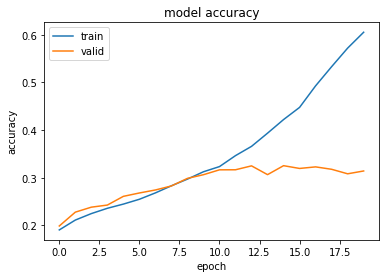

                       precision    recall  f1-score   support

            Biography       0.00      0.00      0.00         5
            Childrens       1.00      0.20      0.33         5
              Fantasy       0.18      0.40      0.25         5
           Historical       0.00      0.00      0.00         5
               Horror       0.00      0.00      0.00         5
      Mystery & Crime       0.00      0.00      0.00         5
               Poetry       0.00      0.00      0.00         5
   Politics & History       0.00      0.00      0.00         5
Religion & Philosophy       0.27      0.80      0.40         5
              Romance       0.36      0.80      0.50         5
      Science Fiction       0.00      0.00      0.00         5
       Sequential Art       1.00      0.80      0.89         5
          Young Adult       0.50      0.40      0.44         5

             accuracy                           0.26        65
            macro avg       0.25      0.26      0.22 

In [228]:
show_results(history,model,survey_ds)


Non normalised samples with transfer learning 

In [36]:
import tensorflow_hub as hub
feature_extractor_model ="https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_model, input_shape=(150, 100, 3), trainable=False)

In [60]:
num_classes=13

model_resnet = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  feature_extractor_layer,
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax')
])
model_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.01,
        epsilon=0.01
    ),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [61]:
history_resnet=model_resnet.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15
)

Epoch 1/15
990/990 [==============================] - 448s 448ms/step - loss: 2.4081 - accuracy: 0.2113 - val_loss: 2.2323 - val_accuracy: 0.2570
Epoch 2/15
990/990 [==============================] - 465s 470ms/step - loss: 2.3104 - accuracy: 0.2297 - val_loss: 2.2131 - val_accuracy: 0.2569
Epoch 3/15
990/990 [==============================] - 465s 470ms/step - loss: 2.3070 - accuracy: 0.2271 - val_loss: 2.2285 - val_accuracy: 0.2565
Epoch 4/15
990/990 [==============================] - 461s 466ms/step - loss: 2.2958 - accuracy: 0.2296 - val_loss: 2.1949 - val_accuracy: 0.2598
Epoch 5/15
990/990 [==============================] - 465s 470ms/step - loss: 2.2904 - accuracy: 0.2344 - val_loss: 2.1896 - val_accuracy: 0.2563
Epoch 6/15
990/990 [==============================] - 455s 459ms/step - loss: 2.2893 - accuracy: 0.2336 - val_loss: 2.1952 - val_accuracy: 0.2588
Epoch 7/15
990/990 [==============================] - 463s 468ms/step - loss: 2.2792 - accuracy: 0.2372 - val_loss: 2.1895 -

In [37]:
num_classes=13

model_resnet2 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  feature_extractor_layer,
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax')
])
model_resnet2.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.001,
        epsilon=0.1
    ),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [38]:
history_resnet2=model_resnet2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15
)

Epoch 1/15
990/990 [==============================] - 455s 455ms/step - loss: 2.7883 - accuracy: 0.1571 - val_loss: 2.2292 - val_accuracy: 0.2735
Epoch 2/15
990/990 [==============================] - 442s 447ms/step - loss: 2.2812 - accuracy: 0.2430 - val_loss: 2.1213 - val_accuracy: 0.3020
Epoch 3/15
990/990 [==============================] - 452s 456ms/step - loss: 2.1871 - accuracy: 0.2724 - val_loss: 2.0768 - val_accuracy: 0.3125
Epoch 4/15
990/990 [==============================] - 449s 454ms/step - loss: 2.1278 - accuracy: 0.2920 - val_loss: 2.0499 - val_accuracy: 0.3237
Epoch 5/15
990/990 [==============================] - 456s 461ms/step - loss: 2.0953 - accuracy: 0.3053 - val_loss: 2.0409 - val_accuracy: 0.3317
Epoch 6/15
990/990 [==============================] - 453s 457ms/step - loss: 2.0582 - accuracy: 0.3152 - val_loss: 2.0177 - val_accuracy: 0.3316
Epoch 7/15
990/990 [==============================] - 457s 462ms/step - loss: 2.0317 - accuracy: 0.3263 - val_loss: 2.0093 -

In [39]:
model_resnet2.save("resnet_nd_15.h5")

In [42]:
history_resnet2_2=model_resnet2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15
)

Epoch 1/15
990/990 [==============================] - 457s 462ms/step - loss: 1.8353 - accuracy: 0.3882 - val_loss: 1.9528 - val_accuracy: 0.3555
Epoch 2/15
990/990 [==============================] - 426s 430ms/step - loss: 1.8169 - accuracy: 0.3953 - val_loss: 1.9520 - val_accuracy: 0.3525
Epoch 3/15
990/990 [==============================] - 428s 432ms/step - loss: 1.8011 - accuracy: 0.3991 - val_loss: 1.9535 - val_accuracy: 0.3543
Epoch 4/15
990/990 [==============================] - 430s 434ms/step - loss: 1.7807 - accuracy: 0.4045 - val_loss: 1.9576 - val_accuracy: 0.3526
Epoch 5/15
990/990 [==============================] - 444s 449ms/step - loss: 1.7683 - accuracy: 0.4105 - val_loss: 1.9523 - val_accuracy: 0.3576
Epoch 6/15
990/990 [==============================] - 456s 460ms/step - loss: 1.7513 - accuracy: 0.4128 - val_loss: 1.9589 - val_accuracy: 0.3564
Epoch 7/15
990/990 [==============================] - 437s 441ms/step - loss: 1.7330 - accuracy: 0.4221 - val_loss: 1.9563 -

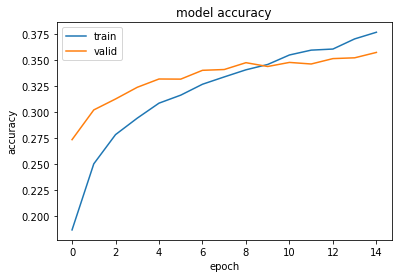

                       precision    recall  f1-score   support

            Biography       0.27      0.13      0.18       169
            Childrens       0.35      0.38      0.36       140
              Fantasy       0.42      0.62      0.50       749
           Historical       0.25      0.32      0.28       383
               Horror       0.20      0.01      0.02       113
      Mystery & Crime       0.30      0.33      0.31       341
               Poetry       0.21      0.03      0.05        96
   Politics & History       0.20      0.13      0.16       189
Religion & Philosophy       0.25      0.26      0.25       262
              Romance       0.42      0.52      0.47       557
      Science Fiction       0.24      0.06      0.09       221
       Sequential Art       0.46      0.52      0.49       138
          Young Adult       0.33      0.19      0.24       388

             accuracy                           0.35      3746
            macro avg       0.30      0.27      0.26 

In [230]:
show_results(history_resnet2,model_resnet2)

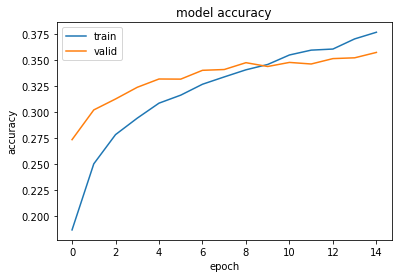

                       precision    recall  f1-score   support

            Biography       0.00      0.00      0.00         5
            Childrens       0.33      0.20      0.25         5
              Fantasy       0.18      0.60      0.27         5
           Historical       0.38      0.60      0.46         5
               Horror       0.00      0.00      0.00         5
      Mystery & Crime       0.33      0.40      0.36         5
               Poetry       0.00      0.00      0.00         5
   Politics & History       0.25      0.20      0.22         5
Religion & Philosophy       0.33      0.40      0.36         5
              Romance       0.43      0.60      0.50         5
      Science Fiction       0.50      0.20      0.29         5
       Sequential Art       0.60      0.60      0.60         5
          Young Adult       0.20      0.20      0.20         5

             accuracy                           0.31        65
            macro avg       0.27      0.31      0.27 

In [231]:
show_results(history_resnet2,model_resnet2,survey_ds)

VGG16 model

In [61]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model

In [86]:
modelVGG = VGG16(include_top=False, input_shape=(150, 100, 3),weights="imagenet",classes=13)
for layer in modelVGG.layers:
   layer.trainable = False

In [70]:
num_classes=13

x=Flatten()(modelVGG.output)
outs = Dense(256,activation='relu')(x)
model_v2=Model(inputs=modelVGG.input,outputs=outs)

model_VGG2 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  model_v2,
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5),
   layers.Dense(256, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax')
])
model_VGG2.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.001,
        epsilon=0.1
    ),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [71]:
history_VGG=model_VGG2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
990/990 [==============================] - 947s 956ms/step - loss: 2.4719 - accuracy: 0.1666 - val_loss: 2.2707 - val_accuracy: 0.2395
Epoch 2/20
990/990 [==============================] - 954s 964ms/step - loss: 2.2941 - accuracy: 0.2253 - val_loss: 2.2047 - val_accuracy: 0.2690
Epoch 3/20
990/990 [==============================] - 955s 965ms/step - loss: 2.2142 - accuracy: 0.2596 - val_loss: 2.1276 - val_accuracy: 0.2931
Epoch 4/20
990/990 [==============================] - 950s 959ms/step - loss: 2.1549 - accuracy: 0.2806 - val_loss: 2.0868 - val_accuracy: 0.3007
Epoch 5/20
990/990 [==============================] - 952s 962ms/step - loss: 2.1289 - accuracy: 0.2898 - val_loss: 2.0567 - val_accuracy: 0.3084
Epoch 6/20
990/990 [==============================] - 949s 959ms/step - loss: 2.1005 - accuracy: 0.3010 - val_loss: 2.0439 - val_accuracy: 0.3158
Epoch 7/20
990/990 [==============================] - 948s 958ms/step - loss: 2.0735 - accuracy: 0.3146 - val_loss: 2.0260 -

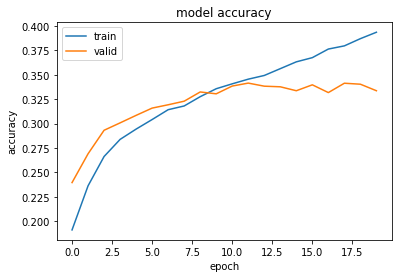

                       precision    recall  f1-score   support

            Biography       0.24      0.14      0.18       169
            Childrens       0.42      0.36      0.38       140
              Fantasy       0.43      0.54      0.48       749
           Historical       0.24      0.16      0.20       383
               Horror       0.00      0.00      0.00       113
      Mystery & Crime       0.32      0.41      0.36       341
               Poetry       0.00      0.00      0.00        96
   Politics & History       0.19      0.23      0.21       189
Religion & Philosophy       0.19      0.44      0.26       262
              Romance       0.50      0.34      0.40       557
      Science Fiction       0.25      0.14      0.17       221
       Sequential Art       0.38      0.49      0.42       138
          Young Adult       0.25      0.24      0.25       388

             accuracy                           0.33      3746
            macro avg       0.26      0.27      0.26 

In [232]:
show_results(history_VGG,model_VGG2)

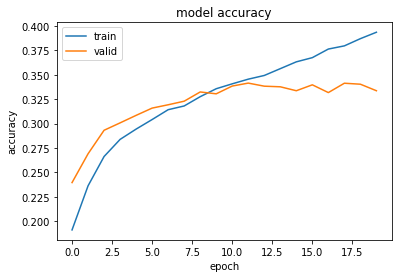

                       precision    recall  f1-score   support

            Biography       0.00      0.00      0.00         5
            Childrens       0.00      0.00      0.00         5
              Fantasy       0.21      0.60      0.32         5
           Historical       0.29      0.40      0.33         5
               Horror       0.00      0.00      0.00         5
      Mystery & Crime       0.20      0.20      0.20         5
               Poetry       0.00      0.00      0.00         5
   Politics & History       0.33      0.40      0.36         5
Religion & Philosophy       0.14      0.40      0.21         5
              Romance       0.67      0.40      0.50         5
      Science Fiction       0.50      0.20      0.29         5
       Sequential Art       0.80      0.80      0.80         5
          Young Adult       0.43      0.60      0.50         5

             accuracy                           0.31        65
            macro avg       0.27      0.31      0.27 

In [233]:
show_results(history_VGG,model_VGG2,survey_ds)